# Assignment 4: Word Embedding Network
In this assignment you will practice how to create a Word Embedding Network in Tensorflow 2.0. First, you will finish some functions to parse the data, build the corpus and construct the skip pair. Then, you will construct a word embedding network by follow the specific requirements and architectures. Finally, you will train the network and visualize the result.

In [111]:
import operator
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras import Model
from keras import optimizers

# split_sentence
1. Remove the special characters from the sentence
2. Filter the short sentence

You can rewrite this function or add more filter conditions

In [240]:
def split_sentence(sentences):
    new_sentence = list()
    for sentence in sentences:
        sentence = sentence.replace("\n", " ")
        sentence = sentence.replace(",", "")
        sentence = sentence.replace("\'", " ")
        sentence = sentence.replace("?", "")
        sentence = sentence.replace("!", "")
        sentence = sentence.replace(";", "")
        sentence = sentence.lower()
        if sentence.count(" ") <= 3:
            continue
        new_sentence.append(sentence)
    return new_sentence

Extract all the sentences from the input file. Split the input into each sentence by calling the "split_sentence" function.

- test_doc_short: Small dataset. You can use it to debug your code.

- test_doc_long: Large dataet. You should use it to get the final result.

In [241]:
file = open("test_doc_long.txt",'r')
raw_data_1 = file.read()
file.close()
sentences = raw_data_1.split(".")
print (len(sentences))
corpus_raw = list()                  
corpus_raw = split_sentence(sentences)
print (corpus_raw[:3])

698
[' dursley of number four privet drive were proud to say that they were perfectly normal thank you very much', ' they were the last people you d expect to be involved in anything strange or mysterious because they just didn t hold with such nonsense', ' dursley was the director of a firm called grunnings which made drills']


# build_dictionary (10 points)
1. Extract the word from the input. 
2. Build a non-duplicate word dictionary.

In [242]:
def build_dictionary(corpus_raw):
    words = []
    # TO DO
    for rawsentence in corpus_raw:
        sentence = rawsentence.strip()
        word = sentence.split(" ")
        words.extend(word)
    # END TO DO
    return set(words)

In [243]:
corpus_dict = build_dictionary(corpus_raw)

- The number of word in "test_doc_long" dataset is around 7.
- The number of word in "test_doc_long" dataset is around 1831.

In [262]:
corpus_dict = build_dictionary(corpus_raw)
corpus_dict = list(corpus_dict)

print (len(corpus_dict))
for i in corpus_dict:
    print(i)

1832

secretary
marge
eight
eggs
snoozed
scented
single
beet
night
exercise
hissing
stove
thank
direction
licking
hands
private
good-bye
"we
seemed
knobbly
dead
hushed
carousel
spoke
fine
tantrum
sixteen
loudly
surprise
markings
beard
unless
narrowed
concrete
safely
anything"
where
stay
"are
rumbling
getting
"borrowed
unable
enough
saturday
missed
toilet
experts
behavior
blame
control
bald
simply
odd
about
nice
complain
sleepiness
already
bolt
flickered
an
roof
boring"
whatever
sweetums"
harvey
camera
of
tidy
wounded
never
building
"exactly"
life"
mysterious
man
faintly
behaving
somewhere
d
sniff
sit"
lots
difference
although
bring
patted
t
sped
brand-new
stiffly
mantelpiece
pulling
expected
majorca"
maps
owned
rumors
sweater
suggested
council
balls)
next
crutches
secondary
drops
"really
letters
so
drumming
largest
taken
violet
true"
any
who
but
"in
s-her-name
itself
fell
windows
fateful
shaped
maroon
disagree
ve
meanwhile
bright
punched
mrs
cara
television
holding
fitted
uneasy
gordon

# one_hot_encoding (10 points)
1. Every word is represented as a vector containing 1 at its position in the vocabulary.

In [263]:
def one_hot_encoding(data_point_index, vocab_size):
    # TO DO
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    # END TO DO
    return temp

# build_word_index_mapping (10 points)
1. Given a word, the function should return the index of this word in dictionary.
2. Given an index, the function should retrieve the word.

In [264]:
def build_word_index_mapping(corpus_dict):   
    # TO DO
    word_2_ind = {}
    ind_2_word = {}
    for i in corpus_dict:
        if i not in word_2_ind:
            word_2_ind[i] = len(word_2_ind)
            ind_2_word[len(word_2_ind)] = i
    # END TO DO
    return word_2_ind, ind_2_word

In [265]:
word_2_ind, ind_2_word = build_word_index_mapping(corpus_dict)

Example Output:
    
1831
1831
1504

In [266]:
print (len(word_2_ind))
print (len(ind_2_word))
print (word_2_ind['he'])

for i in word_2_ind.keys():
    print(i)

1832
1832
868

secretary
marge
eight
eggs
snoozed
scented
single
beet
night
exercise
hissing
stove
thank
direction
licking
hands
private
good-bye
"we
seemed
knobbly
dead
hushed
carousel
spoke
fine
tantrum
sixteen
loudly
surprise
markings
beard
unless
narrowed
concrete
safely
anything"
where
stay
"are
rumbling
getting
"borrowed
unable
enough
saturday
missed
toilet
experts
behavior
blame
control
bald
simply
odd
about
nice
complain
sleepiness
already
bolt
flickered
an
roof
boring"
whatever
sweetums"
harvey
camera
of
tidy
wounded
never
building
"exactly"
life"
mysterious
man
faintly
behaving
somewhere
d
sniff
sit"
lots
difference
although
bring
patted
t
sped
brand-new
stiffly
mantelpiece
pulling
expected
majorca"
maps
owned
rumors
sweater
suggested
council
balls)
next
crutches
secondary
drops
"really
letters
so
drumming
largest
taken
violet
true"
any
who
but
"in
s-her-name
itself
fell
windows
fateful
shaped
maroon
disagree
ve
meanwhile
bright
punched
mrs
cara
television
holding
fitted
unea

In [267]:
sentences = corpus_raw

In [268]:
print(sentences[:3])

[' dursley of number four privet drive were proud to say that they were perfectly normal thank you very much', ' they were the last people you d expect to be involved in anything strange or mysterious because they just didn t hold with such nonsense', ' dursley was the director of a firm called grunnings which made drills']


In [269]:
WINDOW_SIZE = 2

# build_skip_pair (10 points)
1. Build the word pair with given window size.

In [270]:
def build_skip_pair(window_size, sentences):
    # TO DO
    data = []
    for rawsentence in sentences:
        sentence = rawsentence.strip()
        sentence = sentence.lower()
        words = sentence.split(" ")
        for i in range(len(words)):
            for j in range(len(words)):
                if(i!=j) and (abs(i-j)<3):
                    temp = [words[i]]
                    temp.append(words[j])
                    data.append(temp)
    # END TO DO
    return data

Example Input:

He is the king .

Example Output: 

[['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king']]

In [271]:
data = build_skip_pair(WINDOW_SIZE, sentences)
print (len(data))
print (data)

32124
[['dursley', 'of'], ['dursley', 'number'], ['of', 'dursley'], ['of', 'number'], ['of', 'four'], ['number', 'dursley'], ['number', 'of'], ['number', 'four'], ['number', 'privet'], ['four', 'of'], ['four', 'number'], ['four', 'privet'], ['four', 'drive'], ['privet', 'number'], ['privet', 'four'], ['privet', 'drive'], ['privet', 'were'], ['drive', 'four'], ['drive', 'privet'], ['drive', 'were'], ['drive', 'proud'], ['were', 'privet'], ['were', 'drive'], ['were', 'proud'], ['were', 'to'], ['proud', 'drive'], ['proud', 'were'], ['proud', 'to'], ['proud', 'say'], ['to', 'were'], ['to', 'proud'], ['to', 'say'], ['to', 'that'], ['say', 'proud'], ['say', 'to'], ['say', 'that'], ['say', 'they'], ['that', 'to'], ['that', 'say'], ['that', 'they'], ['that', 'were'], ['they', 'say'], ['they', 'that'], ['they', 'were'], ['they', 'perfectly'], ['were', 'that'], ['were', 'they'], ['were', 'perfectly'], ['were', 'normal'], ['perfectly', 'they'], ['perfectly', 'were'], ['perfectly', 'normal'], ['pe

# build_train_data_label
1. Iterate all the word pairs in data
2. Construct the train and label data

In [272]:
def build_train_data_label(data, word_2_ind, vocab_size):
    x_train = [] 
    y_train = [] 
    for data_word in data:
        x_train.append(one_hot_encoding(word_2_ind[ data_word[0] ], vocab_size))
        y_train.append(one_hot_encoding(word_2_ind[ data_word[1] ], vocab_size))
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    return x_train, y_train

In [273]:
x_train, y_train = build_train_data_label(data, word_2_ind, len(corpus_dict))

Preprocess the dataset with batch size 8.

In [274]:
print(x_train.shape, y_train.shape)

dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))

dataset = dataset.shuffle(100).batch(8)

(32124, 1832) (32124, 1832)


# MyEmbeddingModel (20 points)
1. init: Define all the layers you will use in the embedding network.
2. call: Define the network layer connectivity:
           - Fully connected with embedding_size/2 hidden neurons
           - Batchnormalization (optional)
           - Relu activation (optional)
           - Fully connected with embedding_size hidden neurons (This should be the word embedding output)
           - Batchnormalization (optional)
           - Relu activation (optional)
           - Fully connected that map to vocab_size output classes
           - Softmax (This should be the classification output)

In [275]:
class MyEmbeddingModel(keras.Model):
  def __init__(self, embedding_size, vocab_size):
    super(MyEmbeddingModel, self).__init__()
    #Example:
        #self.d2 = Dense(embedding_size)
        #self.d3 = Dense(vocab_size, activation = 'softmax')
    
    # TO DO
    self.d2 = Dense(embedding_size / 2,activation = 'relu')
    self.d3 = Dense(vocab_size,activation = 'softmax')
    # END TO DO

  def call(self, x):
    #Example:
        #x_2 = self.d2(x_1)
        #x_3 = self.d3(x_2)
        
    # TO DO
    x_2 = self.d2(x)
    x_3 = self.d3(x_2)

    # END TO DO
    return x_2, x_3 

In [276]:
embedding_size = 300
vocab_size = len(corpus_dict)
model = MyEmbeddingModel(embedding_size, vocab_size)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
print(model)

# Optimizer (10 points)
- Implement the SGD optimizer
- Implement the RMSprop optimizer
- Implement the Adagrad optimizer
- Implement the Adadelta optimizer
- Implement the Adam optimizer (Use the Adam optimizer for training)

In [277]:
# Example: optimizer = tf.keras.optimizers.Adamax()
# optimizer = #SGD optimizer
# optimizer = #RMSprop optimizer
# optimizer = #Adagrad optimizer
# optimizer = #Adadelta optimizer
optimizer =  tf.keras.optimizers.Adam()
model.compile(loss = "categorical_crossentropy",optimizer = optimizer)

Define the training step. Calculate the loss and optimize the weights.

In [278]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:

        _, predictions = model(inputs, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss = tf.reduce_mean(loss)

    return train_loss, labels, predictions

Example Output:

    Epoch 0, Loss: 6.393890857696533
    Epoch 1, Loss: 5.391612529754639
    Epoch 2, Loss: 4.996224403381348
    Epoch 3, Loss: 4.692948341369629
    Epoch 4, Loss: 4.473527908325195
    Epoch 5, Loss: 4.335629940032959
    Epoch 6, Loss: 4.251341342926025
    Epoch 7, Loss: 4.205460071563721
    Epoch 8, Loss: 4.172143936157227
    Epoch 9, Loss: 4.1499714851379395
    Epoch 10, Loss: 4.129685878753662
    ......

In [286]:
EPOCHS = 50

for epoch in range(EPOCHS):
    batch_loss = 0.0
    num_batch = 0
    for (batch, (inputs, labels)) in enumerate(dataset):
        train_loss, labels, predictions = train_step(inputs, labels)
        batch_loss += train_loss
        num_batch += 1
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch, batch_loss/num_batch))

Epoch 0, Loss: 3.56957745552063
Epoch 1, Loss: 3.564134120941162
Epoch 2, Loss: 3.5644805431365967
Epoch 3, Loss: 3.562847137451172
Epoch 4, Loss: 3.5547752380371094


KeyboardInterrupt: 

# build_embedding_dict (10 points)
1. Iterate the corpus_dict and generate the embedding for each word.
2. Use the trained model to generate the word embedding with given one-hot embedding word.
3. Store the word and embedding in a dictionary. The key should be the word. The value should be the embedding vector.

In [280]:
def build_embedding_dict(model, corpus_dict):
    embeddings = dict()
    # TO DO

    # example (use the trained model to generate the word embedding with given one-hot embedding word): sample_embedding, _ = model(sample_one_hot)
    x = np.array([])
    for i in corpus_dict:
        one_hot = one_hot_encoding(word_2_ind[i], len(corpus_dict))
        x = np.append(x,one_hot)
    x = x.reshape(vocab_size,vocab_size)
    x_2,x_3 = model(x)
    for i in range(len(corpus_dict)):
        embeddings[corpus_dict[i]] = x_3[i]
    # END TO DO
    return embeddings

# euclidean_dist_np (10 points)
1. Calculate the Euclidean distance between two input vectors.

In [281]:
def euclidean_dist_np(vec1, vec2):
    dist = 0.0
    # TO DO
    dist = np.linalg.norm(vec1-vec2)
    
    # END TO DO
    return dist

# find_closest (10 points)
1. Calculate the euclidean distance between the given word and all the words in embedding dictionary.
2. Sort the dictionary by value in ascending order.
3. Return the first three closet words.

In [282]:
def find_closest(word, embeddings):
    result = dict()
    # TO DO
    word_one_hot = one_hot_encoding(word_2_ind[word],vocab_size)
    a,word_emb = model(word_one_hot[np.newaxis,:])
    for i in embeddings:
        dist = euclidean_dist_np(word_emb,embeddings[i])
        result[i] = dist
    result_list = sorted(result.items(),key = lambda item:item[1])
    # END TO DO
    return result_list[:3]

Example Output: 

[('she', 0.0), ('he', 5.3993783), ('they', 5.7223315)]

In [283]:
embedding_dict = build_embedding_dict(model, corpus_dict)
print(find_closest('she', embedding_dict))

[('she', 1.4513529e-07), ('he', 0.14129622), ('it', 0.16998793)]


# visualize_cluster
1. Visualize the word embedding in 2D space

In [284]:
def visualize_cluster(embedding_dict): 
    labels = []
    tokens = []
    for w in embedding_dict.keys():
        labels.append(w)
        tokens.append(embedding_dict[w])
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
    plt.show()

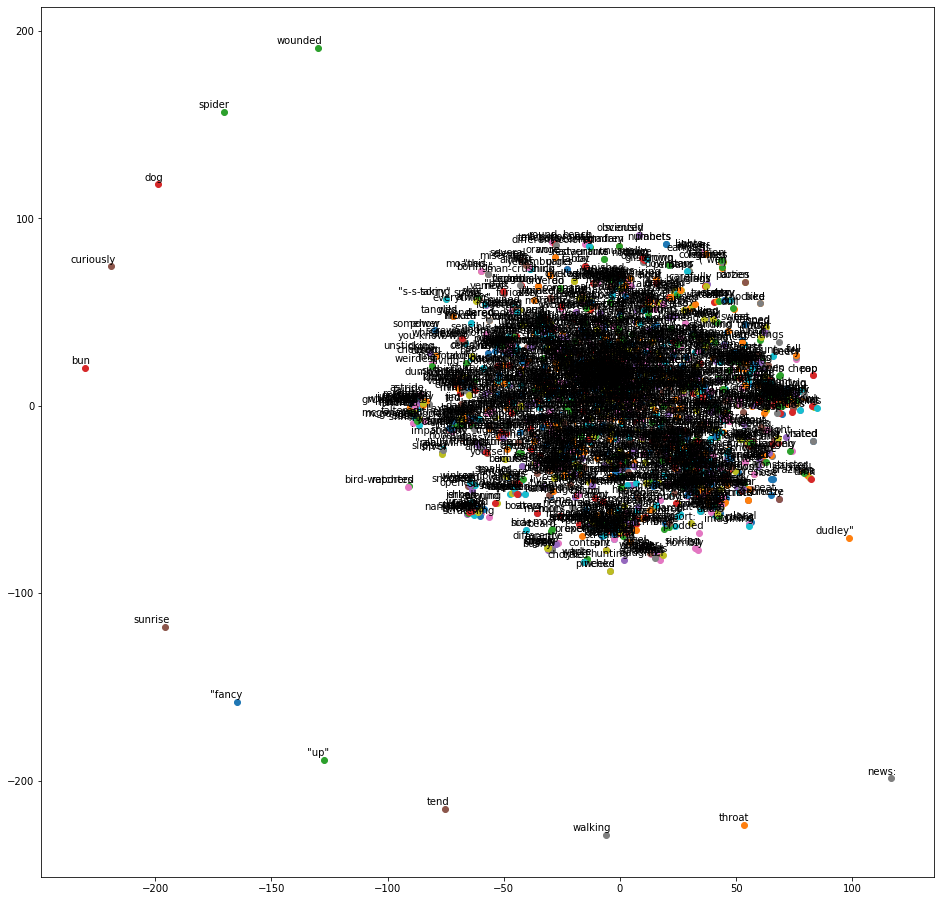

In [285]:
visualize_cluster(embedding_dict)